SINDy for cell apoptosis. This is meant to show the efficacy of SINDy compared to the neural network based approach.


### Instructions 
1. Connect to a run-time, not GPU
2. Run all cells for default configurations.
3. Play around with noise, sparsity, basis functions, etc.

This supplements the presentation for APPM 5720: Data Driven Modeling.
Authors: Josh Myers-Dean, Leonardo Orozco, and Wenhao Wang

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joshmyersdean/APPM5720-SBINN/blob/main/sindy.ipynb)

# Setting up the environment

In [1]:
!pip install pysindy==0.15
!pip install 'scikit-learn<1'

In [2]:
import numpy as np
from scipy.integrate import odeint
import pysindy as ps
import warnings
import matplotlib.pyplot as plt
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

# Apoptosis Model Data generation

You can find the full version of parameter settings <br>
At time 0, our initial condition is $x(0) = [1.34 × 10^5, 1.0 ×
10^5, 2.67 × 10^5, 0.0, 0.0, 0.0, x_7^0 ,0.0]$ (molecules/cell)<br>
when $x^0_7 =2.9 × 10^3$
leads to cell death
and $x^0_7 = 2.9 × 10^4$
leads to cell survival.

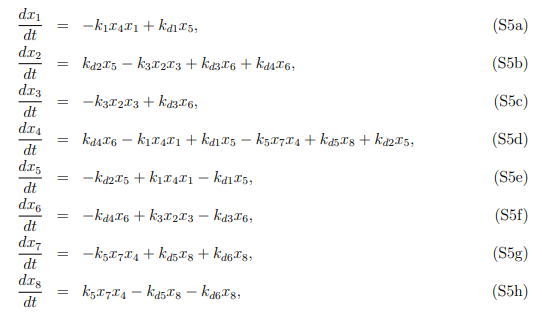

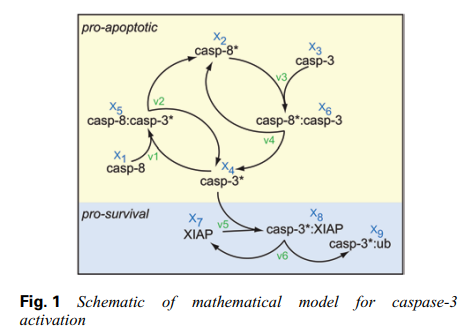

## Then we make a function for the system of ODE describe the apoptosis process

In [3]:
def apoptosis_model(
    t, x0, k1, kd1, kd2, k3, kd3, kd4, k5, kd5, kd6,
):
    def func(x, t):
        v4_1 = kd1 * x[4]
        v4_2 = kd2 * x[4]
        v5_3 = kd3 * x[5]
        v5_4 = kd4 * x[5]
        v7_5 = kd5 * x[7]
        v7_6 = kd6 * x[7]
        v03 = k1 * x[3] * x[0]
        v12 = k3 * x[1] * x[2]
        v36 = k5 * x[6] * x[3]

        return [
            -v03 + v4_1,
            v4_2 - v12 + v5_3 + v5_4,
            -v12 + v5_3,
            v5_4 - v03 + v4_1 - v36 + v7_5 + v4_2,
            -v4_2 + v03 - v4_1,
            -v5_4 + v12 - v5_3,
            -v36 + v7_5 + v7_6,
            v36 - v7_5 - v7_6,
        ]

    return odeint(func, x0, t)

## Then we solve the system from time 0 to 60 hours (0.1 hour increment), we also non-dimensionalize the data and add some noise in this step
The noise we add here is the white noise follows gaussian distribution.<br>
$ϵ \sim Guassian(0,noise\cdot std(x_i))$

In [4]:
noise=0.002    # select your noise level, note that the precision of prediction will decay very fast!

In [5]:
t = np.arange(0, 60, 0.1)[:, None]
t_scale = 3600
c_scale = 1e1

# Data
x7=2.9e3  # death
#x7=2.9e4  # survival
x0 = [1.34e5, 1e5, 2.67e5, 0, 0, 0, x7, 0] 
x0 = [x / c_scale for x in x0]
var_list = [2.67e-9, 1e-2, 8e-3, 6.8e-8, 5e-2, 1e-3, 7e-5, 1.67e-5, 1.67e-4]
var_list = [v * t_scale for v in var_list]
for i in [0, 3, 6]:
    var_list[i] *= c_scale
y = apoptosis_model(np.ravel(t), x0, *var_list)
yclean=np.copy(y)
# Add noise
if noise > 0:
    std = noise * y.std(0)
    tmp = np.copy(y[len(t) // 2])
    y[1:, :] += np.random.normal(0, std, (y.shape[0] - 1, y.shape[1]))
    y[len(t) // 2] = tmp


## Select the observations from y

In [6]:
train_number=500 # select your train number from 0 to 550

In [7]:
yobserve=y[0:train_number,:]

## Now we can visualize the $x_i$

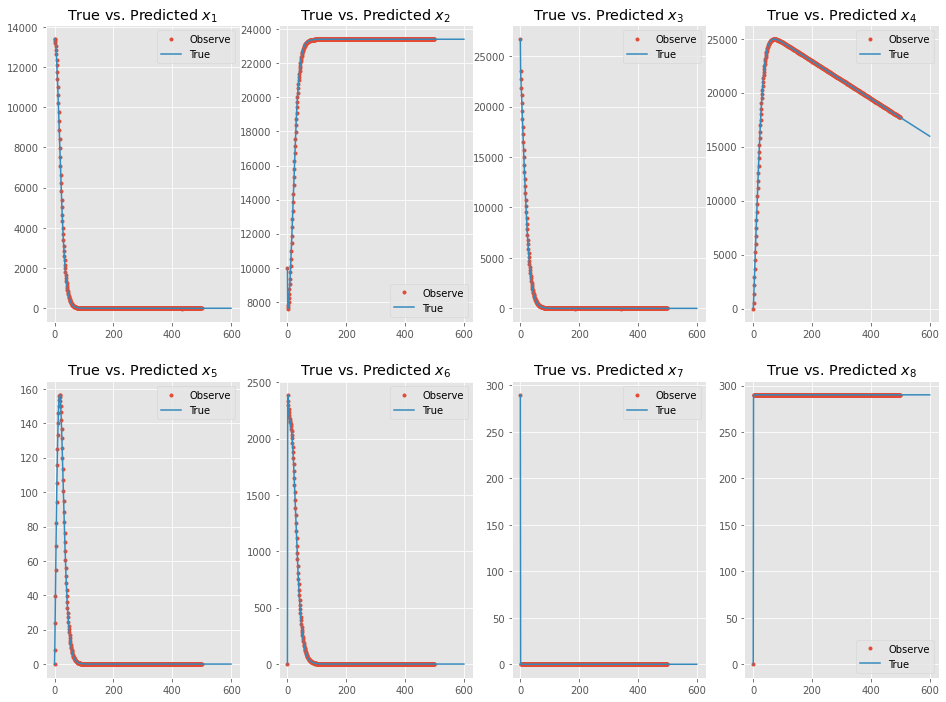

In [8]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
fig, ax = plt.subplots(2,4, figsize=(16,12))
ax = ax.flatten()
for i in range(y.shape[1]):
  ax[i].plot(yobserve[:, i], 'o', markersize=3,label='Observe')
  ax[i].plot(yclean[:, i], label='True')
  ax[i].set_title(f"True vs. Predicted $x_{i+1}$")
  ax[i].legend()

## SINDy

In [9]:
thrs=0.025  #select your threshold from 0 to 1.

In [10]:
optimizer = ps.STLSQ(threshold=thrs)
model = ps.SINDy(
    feature_library=ps.PolynomialLibrary(degree=1),
    feature_names=["x1", "x2", 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'],
    optimizer=optimizer
)
model.fit(y[0:train_number,:], t=.1)
model.print()

x1' = -16753.776 1 + 0.011 x1 + 0.191 x2 + 0.127 x3 + -24.192 x5 + -0.128 x6 + 39.430 x7 + 42.394 x8
x2' = 225738.090 1 + 6.950 x1 + -10.136 x2 + -14.506 x3 + -417.747 x5 + 36.385 x6 + 432.567 x7 + 39.480 x8
x3' = 222336.501 1 + 6.225 x1 + -10.217 x2 + -13.956 x3 + -429.338 x5 + 30.885 x6 + 402.098 x7 + 57.766 x8
x4' = 4833.176 1 + 0.418 x1 + -1.017 x2 + -1.215 x3 + -35.522 x5 + 6.290 x6 + 120.423 x7 + 64.814 x8
x5' = 852.014 1 + 0.046 x1 + -0.054 x2 + -0.056 x3 + -2.013 x5 + 1.954 x7 + 1.394 x8
x6' = -232834.155 1 + -6.975 x1 + 10.006 x2 + 14.414 x3 + 443.357 x5 + -36.187 x6 + -394.544 x7 + -4.590 x8
x7' = 27410.392 1 + 0.847 x1 + -1.195 x2 + -1.709 x3 + -52.002 x5 + 4.087 x6 + 46.538 x7 + 1.887 x8
x8' = -27366.623 1 + -0.849 x1 + 1.193 x2 + 1.709 x3 + 52.005 x5 + -4.090 x6 + -46.530 x7 + -1.873 x8


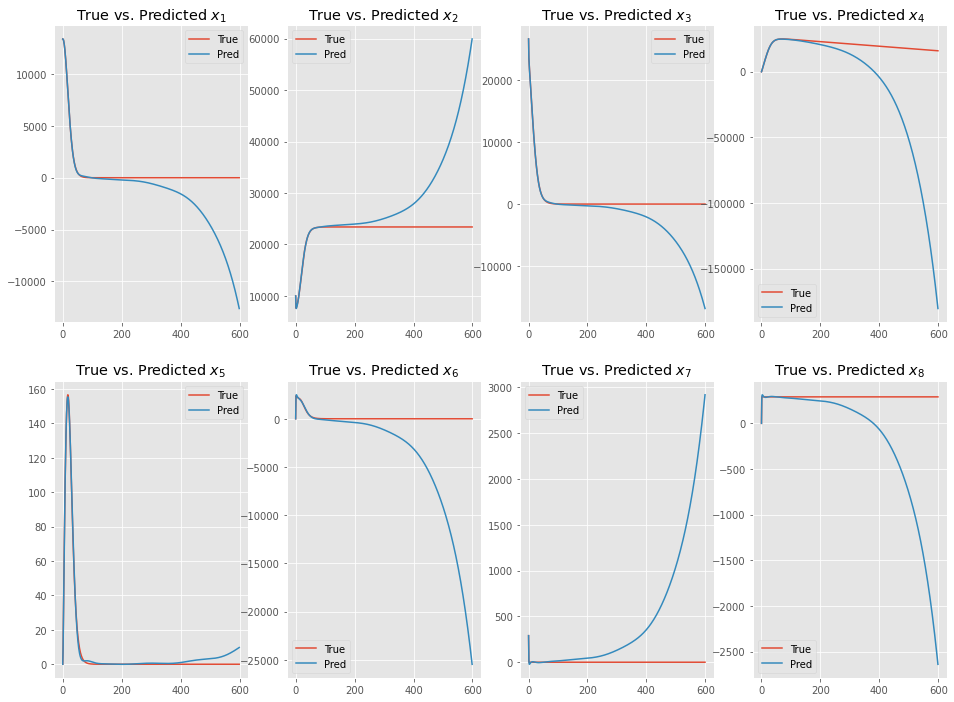

In [11]:
sim = model.simulate(x0 = x0, t=t[:,0])
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
fig, ax = plt.subplots(2,4, figsize=(16,12))
ax = ax.flatten()
for i in range(y.shape[1]):
  ax[i].plot(yclean[:, i], label='True')
  ax[i].plot(sim[:, i], label='Pred')
  ax[i].set_title(f"True vs. Predicted $x_{i+1}$")
  ax[i].legend()
